# Data download

Experimental dataset can be downloaded from [https://doi.org/10.5281/zenodo.11284051](https://doi.org/10.5281/zenodo.11284051).


Here, we download and decompress the data into the Downloas folder.

In [27]:
import requests
from tqdm import tqdm, trange
from pathlib import Path
import os
import zipfile

def download(url, fname):
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get('content-length', 0))
    with open(fname, 'wb') as file, tqdm(
            desc=fname,
            total=total,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)
            
def extract(filename):
    dir_name = filename[:-4]
    os.mkdir(dir_name)
    with zipfile.ZipFile(filename, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting '):
            try:
                zf.extract(member, dir_name)
            except zipfile.error as e:
                pass

In [15]:
downloads_path = str(Path.home() / 'Downloads')

url_data = 'https://zenodo.org/records/11284051/files/h5_files_s2ism.zip'
name_data = 'h5_files_s2ism.zip'

filename = os.path.join(downloads_path, name_data)

C:\Users\alzunino\Downloads\h5_files_s2ism.zip


In [16]:
if not os.path.isfile(filename):
    print('Downloading data:' + filename + '\n)
    download(url_data, filename)
else:
    print('File already downloaded.')

C:\Users\alzunino\Downloads\h5_files_s2ism.zip: 100%|██████████| 3.65G/3.65G [09:00<00:00, 7.26MiB/s]


In [28]:
dir_name = filename[:-4]

if not os.path.isfile(dir_name):
    print('Extracting compressed data:\n')
    extract(filename)

Extracting compressed data:



Extracting : 100%|██████████| 16/16 [04:44<00:00, 17.79s/it]


In [30]:
# Data loading

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import os

import brighteyes_ism.analysis.Graph_lib as gra                    # library for data visualization
from brighteyes_ism.analysis import APR_lib as apr                 # import library to perform shift-vector analysis
from brighteyes_ism.analysis import Tools_lib as tool              # general-purpose library
import brighteyes_ism.simulation.PSF_sim as sim                    # library for PSFs simulation
import brighteyes_ism.dataio.mcs as mcs                            # library for reading experimental data

from s2ism import mag_finder as mag                                # library needed to perform magnification retrieval on the raw ISM data
from s2ism import shift_vectors_minimizer as svm                   # library to perform shift-vectors estimation
from s2ism import psf_estimator as est                             # library to simulate proper PSFs
from s2ism import s2ism as s2                                      # library containing the core functions of the algorithm

Here, we load the ISM raw dataset.

In [33]:
file = 'HeLa_cell_A_tubulin_data-16-12-2022-18-20-18.h5'

fullpath = os.path.join(dir_name, file)

data, meta = mcs.load(fullpath)

The h5 file contains a 6D dataset: repetition, z, y, x, time, channel.

This dataset is planar and in this notebook we do not use the temporal dimension.
Thus, we sum over the dimensions that are not needed.

In [34]:
dset = data.sum(axis=(0,1,4))

We show the raw ISM dataset. In this representation, each image normalize to itself.

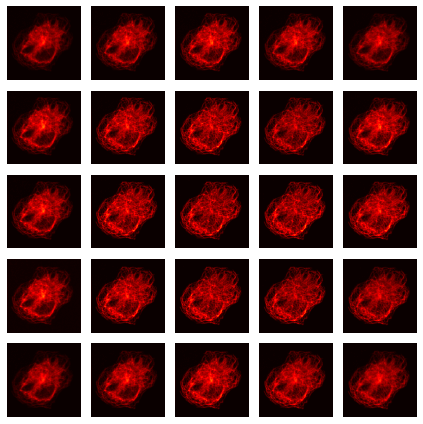

In [35]:
fig_1 = gra.ShowDataset(dset)

Now we show the ISM dataset with each image normalized with respect to the full set.

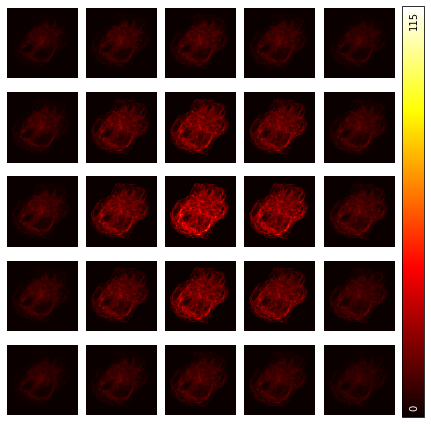

In [36]:
fig_2 = gra.ShowDataset(dset, normalize = True, colorbar=True)

We print the metadata with the experimental parameters.

nx, ny, nz are the number of pixels for each axis.

rangex, rangey, rangez is the field of view for each axis ($\mu m$).

nbin the number of temporal bin used to acquire the data.

dt is the width temporal bin ($\mu s$).


In [6]:
meta.Print()

version       0.0.1
comment       
rangex        35.0
rangey        35.0
rangez        0.0
nbin          50
dt            1.0
nx            875
ny            875
nz            1
nrep          1
calib_x       17.303
calib_y       17.409
calib_z       10.0


# PSF estimation and generation

We relieve the need of acquiring experimental PSFs by simulating them using [BrightEyes-ISM](https://github.com/VicidominiLab/BrightEyes-ISM).

In order to have simulations close as much as possible to the PSFs of our microscope, we take into account every spatial deformation occuring in the acquisition step.

The parameters needed to fit the deformations are retrieved from the ISM data itself through a minimization algorithm.

The steps are the following:


## Shift-vectors extraction

We calculate the shift-vectors of the ISM dataset.

In [7]:
pxs = meta.dx*1e3             # pixel size of the ISM dataset converted in nm (metadata saves the pixel size in micrometers)
upsampling_factor = 10        # upsampling factor to improve accuracy in simulation
Nch = dset.shape[-1]
reference = Nch // 2  #the reference image for the shift vectors extraction is the central one

shift_vectors, _ = apr.ShiftVectors(dset, upsampling_factor, reference, filter_sigma=1)
shift_vectors *= pxs # we convert the shifts from pixels units to nm

We plot the shift-vectors color coding each point using the fingeprint

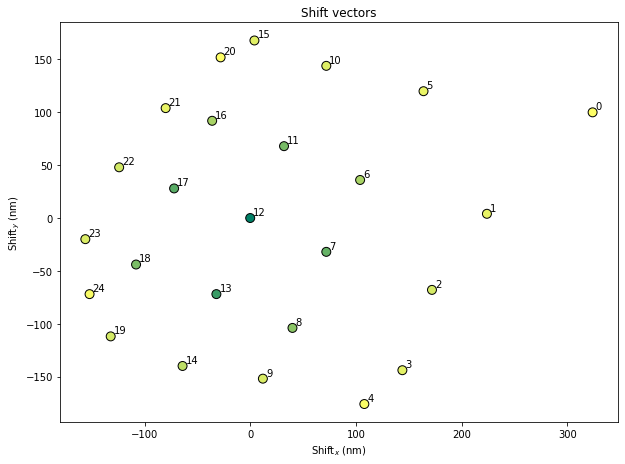

In [8]:
fig_3, ax_3 = plt.subplots(figsize = (10, 10))

fing = tool.fingerprint(dset)
_ = gra.PlotShiftVectors(shift_vectors, color=fing, fig = fig_3, ax = ax_3)

We want to simulate a set of PSFs featured by this shift-vectors arrangement.

So, we perform a shift-vectors fitting through parameters' estimation.

First step is the creation of a phantom set of shift-vectors to fit with the experimental ones.

We do that by considering the central 3x3 ring of shifts, that is usually squared-like in shape.

We simulate a 3x3 grid of shift vectors with pixel-size as lateral displacement.

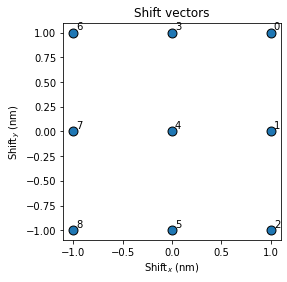

In [9]:
#creation of the phantom grid 
shift_sim = svm.shift_matrix()

fig_4 = gra.PlotShiftVectors(shift_sim)

We crop the 5x5 experimental shift-vectors to obtain the 3x3 central ring.

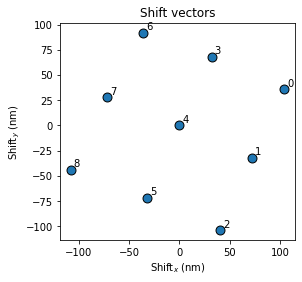

In [10]:
#shift-vectors crop 
shift_vectors_crop = svm.crop_shift(shift_vectors)

fig_5 = gra.PlotShiftVectors(shift_vectors_crop)

## Parameters estimation

Now we fit the experimental shift vectors to the following model:

$$ \hat{\rho}, \hat{\theta}, \hat{\alpha} = \mathrm{argmin}_{\rho, \theta, \alpha} = ||{ \mu^{\text{(exp)}} - T(\rho, \theta, \alpha) m }^2 ||_F $$

where $\mu^{\text{(exp)}}$ are the experimental shift-vectors from the $3 \times 3$ inner array, $T$ is the transformation matrix, and $m$ the normalized coordinates of the detector array.

The optimal mirroring, rotation, and dilatation parameters are $ \hat{\rho}, \hat{\theta}, \hat{\alpha}$, respectively.

In [11]:
parameters = svm.find_parameters(shift_vectors)  #retrieving the triplet of parameters from the experimental data

In [12]:
print(f'Dilation = {parameters[0]:.2f} nm')
print(f'Rotation = {parameters[1]:.2f} rad')
print(f'Mirroring = {parameters[2]:.2f}')

Dilation = 77.30 nm
Rotation = -0.42 rad
Mirroring = 1.00


We transform the phantom shift-vectors according to the retrieved parameters

In [13]:
shift_sim_rot = svm.transform_shift_vectors(parameters, shift_sim)

We visualize the fitting result

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Shift vectors'}, xlabel='Shift$_x$ (nm)', ylabel='Shift$_y$ (nm)'>)

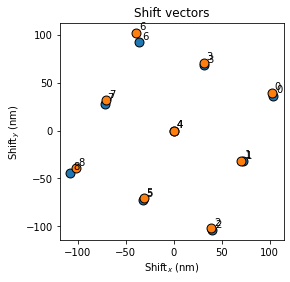

In [14]:
fig_6, ax = gra.PlotShiftVectors(shift_vectors_crop)
gra.PlotShiftVectors(shift_sim_rot, fig = fig_6, ax = ax)

## Magnification
We retrieve the magnification factor of our ISM microscope through a minimization process on the dilatation parameter $\hat{\alpha}$ predicted before:

$$ \hat{M} = \mathrm{argmin}_M || \hat{\alpha} - \mu(M) ||_2^2$$

where $\mu(M)$ is the shift calculated approximating the 1D PSF with the scalar diffraction theory.
The first step is to collect the parameters characterizing the ISM microscope:

In [1]:
na = 1.4   # numerical aperture
ex_wl = 640   # excitation wavelength [nm]
em_wl = 660   # emission wavelength [nm]
pxpitch = 75e3  # detector pixel pitch [nm]
pxdim = 50e3  # detector pixel size [nm]

Second step, launch the magnification retrieval process

In [16]:
mag = mag.find_mag(parameters[0], ex_wl, em_wl, pxpitch, pxdim, na)

print(f'Magnification value retrieved = {mag:.2f}')

Magnification value retrieved = 453.91


## Out-of-focus position


To choose at which depth pose the out-of-focus plane for the reconstruction, we simulate a stack of PSFs over a depth range equal to the Depth Of Field (DOF).

We define the parameters of the microscope as attributes of the following objects:

In [17]:
exPar = sim.simSettings()
exPar.na = 1.4   # numerical aperture
exPar.wl = 640   # wavelength [nm]
exPar.gamma = 45 # parameter describing the light polarization
exPar.beta = 90  # parameter describing the light polarization
exPar.n = 1.5    # refractive index of immersion medium
exPar.mask_sampl = 50       #sampling points of the phase mask in simulation

emPar = exPar.copy()
emPar.wl = 660   # wavelength [nm]

grid = sim.GridParameters()
grid.N = 5  # number of elements for each axis of the detector array, assumed squared
grid.pxpitch = 75e3  # detector pixel pitch [nm]
grid.pxdim = 50e3  # detector pixel size [nm]
grid.pxsizex = meta.dx*1e3 # pixel size of acquisition [nm]
grid.M = mag

Then we perform a similarity measure between the in-focus set of PSFs and each element of the stack. The plane that minimize the similarity defines the distance between the two reconstruction planes.

The similarity measure can stand both on the Pearson correlation and Kullback-Leibler Divergence, passing as input to the function the mode='KL' or 'Pearson'.

Calculating the PSFs stack from z = 0.0 nm to z = 1416.0 nm:


100%|██████████| 60/60 [13:21<00:00, 13.36s/it]


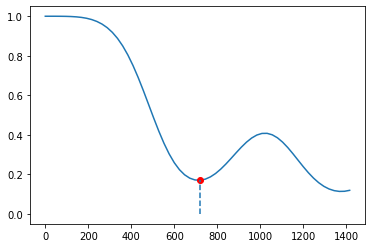

In [18]:
optimal_bkg_plane, psf_stack = est.find_out_of_focus_from_param(grid.pxsizex, exPar, emPar, mode ='Pearson', stack='positive', graph = True)

In [19]:
print(f'Optimal out-of-focus position = {optimal_bkg_plane} nm')

Optimal out-of-focus position = 720.0 nm


## PSF simulation

Defining the grid_simul through the class GridFinder we initialize the parameters grid needed to start the algorithm. Then, with the method estimate, we fill the latter with the optimal parameters of magnification, rotation ad disposition:

In [20]:
grid_simul = est.GridFinder(grid)
grid_simul.estimate(dset, exPar.wl, emPar.wl, emPar.na)

Here we show the upsampling step performed by hand in pre-simulation. We fix the upsampling factor to 10, and we shrink tenfold the pixel size while enlarging tenfold the number of pixels in simulation.
We do that to improve the fitting accuracy of the process mentioned in the 'Parameters Estimation' section.

In [21]:
ups = 10

grid_simul.Nz=2
grid_simul.pxsizex=meta.dx*1e3/ups
grid_simul.pxsizez=optimal_bkg_plane
grid_simul.Nx = 100*ups

psf, det_psf, ex_psf = sim.SPAD_PSF_3D(grid_simul, exPar, emPar)

Calculating the PSFs stack from z = -720.0 nm to z = 0.0 nm:


100%|██████████| 2/2 [20:38<00:00, 619.15s/it]


We plot the complete PSFs, the out-of-focus and in-focus one.

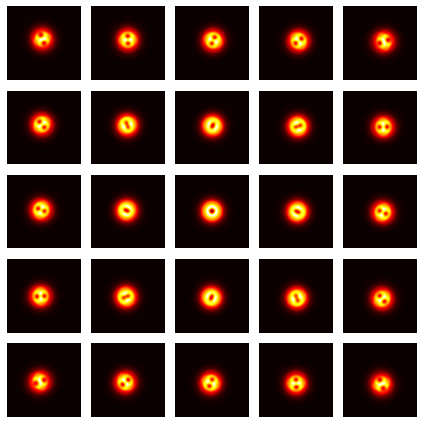

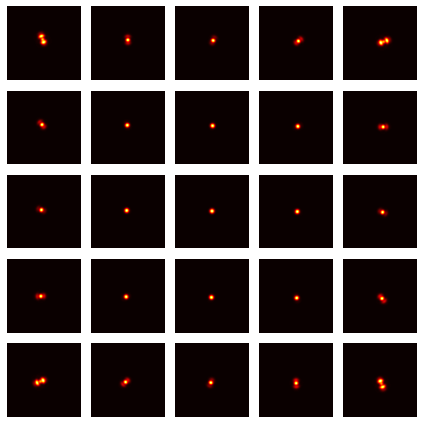

In [22]:
fig1 = gra.ShowDataset(psf[0])
fig2 = gra.ShowDataset(psf[1])

Let us check if the shift vectors extracted from the simulated PSFs matches with the central 3x3 set of experimental shift vectors.


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Shift vectors'}, xlabel='Shift$_x$ (nm)', ylabel='Shift$_y$ (nm)'>)

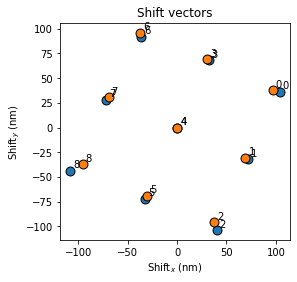

In [23]:
ref = 12           # we define the SPAD channel chosen as reference to perform the cross correlation for the shift vector extraction
shift_PSF = apr.APR(psf[0] , 10 , ref)[0]*grid_simul.pxsizex

fig, ax = gra.PlotShiftVectors(svm.crop_shift(shift_vectors))
gra.PlotShiftVectors(svm.crop_shift(shift_PSF), fig = fig, ax = ax)

Here we have the function that simulate the ISM PSFs embedding all the parameter retrieval processes described before.

In this case we already know the optimal out-of-focus depth for the reconstruction (calculated before), so we pass as 'z_out_of_focus' the numerical value in nm. If we set z_out_of_focus = 'ToFind' the function will automatically find it.

The downsampling procedure is performed automatically, just by passing a boolean input defined as 'downsampling' as True.
The upsampling factor is adaptively calculated in order to reach a pixel size of simulation close to $\frac{AU}{100}$ where $AU = \frac{1.22 \lambda_{em}}{NA}$.

In [24]:
grid.Nz = 2
grid.pxsizex = meta.dx*1e3
grid.pxsizez = optimal_bkg_plane

psf, det_psf, ex_psf = est.psf_estimator_from_data(dset, exPar, emPar, grid, z_out_of_focus = optimal_bkg_plane)

Calculating the PSFs stack from z = -720.0 nm to z = 0.0 nm:


100%|██████████| 2/2 [11:28<00:00, 344.37s/it]


# Reconstructing the ISM data

Now we can perform the s$^2$ISM reconstruction. The iterative gradient-descent rule is the following

$$ o^{m+1}_{j}(\mathbf{x_s})=o^m_{j} (\mathbf{x_s}) \left[\int h_j(-\mathbf{x_s}|\mathbf{x_d})*\frac{i(\mathbf{x_s}|\mathbf{x_d})}{\sum_{k=1}^2[o^m_k(\mathbf{x_s})*h_k(\mathbf{x_s}|\mathbf{x_d})]}d\mathbf{x_d} \right ] \quad \text{for}\quad j=1,2 $$

In [25]:
recon_obj , counts, diff, k = s2.max_likelihood_reconstruction(dset, psf, stop = 'fixed', max_iter = 10)

Progress: 11it [00:04,  2.72it/s]                        


We generate the equivalent confocal image

In [26]:
img_sum = dset.sum(axis=-1)

and compare the results

(<Figure size 1080x360 with 6 Axes>,
 <AxesSubplot:label='C', title={'center':'Background rejected'}>)

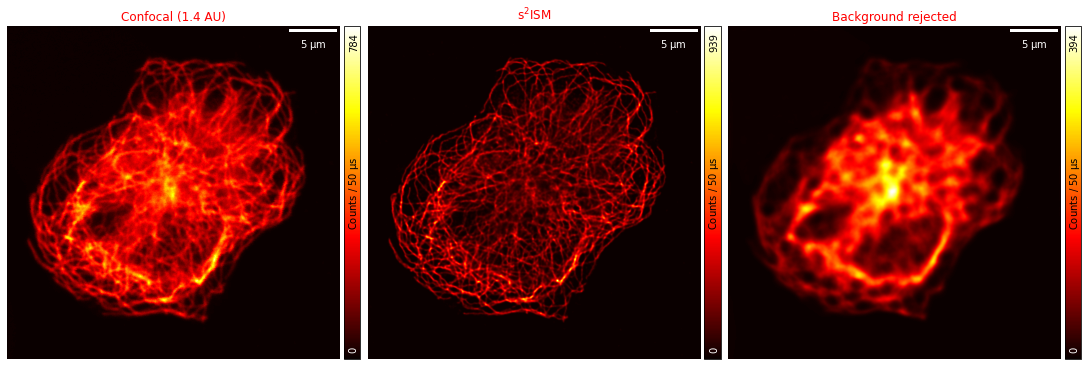

In [27]:
fig = plt.figure(layout="constrained", figsize = (15, 5))
axd = fig.subplot_mosaic(
    """
    ABC
    """
)

axd["A"].set_title(r'Confocal (1.4 AU)', color = 'red')
gra.ShowImg(img_sum[5:,5:], grid.pxsizex*1e-3, cmap='hot', fig = fig, ax = axd["A"], clabel = meta.pxdwelltime)

axd["B"].set_title(r's$^2$ISM', color = 'red')
gra.ShowImg(recon_obj[1,5:,5:], grid.pxsizex*1e-3, cmap='hot', fig = fig, ax = axd["B"], clabel = meta.pxdwelltime)

axd["C"].set_title(r'Background rejected', color = 'red')
gra.ShowImg(recon_obj[0,5:,5:], grid.pxsizex*1e-3, cmap='hot', fig = fig, ax = axd["C"], clabel = meta.pxdwelltime)

Here we zoom in a smaller region

(<Figure size 720x360 with 4 Axes>,
 <AxesSubplot:label='B', title={'center':'s$^2$ISM'}>)

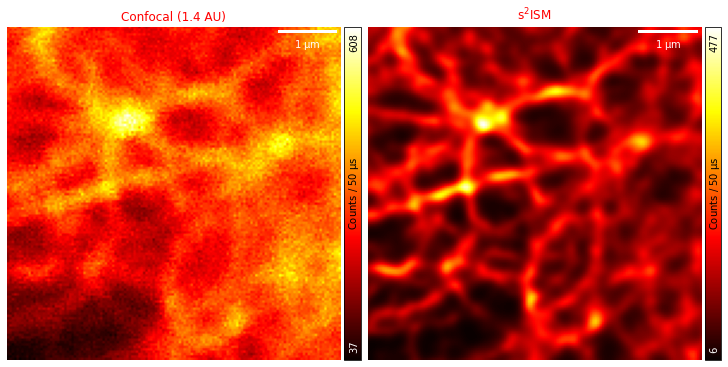

In [28]:
fig = plt.figure(layout="constrained", figsize = (10, 5))
axd = fig.subplot_mosaic(
    """
    AB
    """
)

axd["A"].set_title(r'Confocal (1.4 AU)', color = 'red')
gra.ShowImg(img_sum[ 360:500, 270:410], grid.pxsizex*1e-3, cmap='hot', fig = fig, ax = axd["A"], clabel = meta.pxdwelltime)

axd["B"].set_title(r's$^2$ISM', color = 'red')
gra.ShowImg(recon_obj[1, 360:500, 270:410], grid.pxsizex*1e-3, cmap='hot', fig = fig, ax = axd["B"], clabel = meta.pxdwelltime)

The energy flux conservation bounds the total amount photons to be conserved, but they can be exchanged between the two planes at each iteration.

Text(0.5, 1.0, 'photon counts')

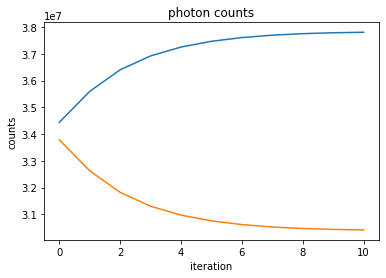

In [29]:
plt.figure()
plt.plot(counts[0])
plt.plot(counts[1])
plt.xlabel('iteration')
plt.ylabel('counts')
plt.title('photon counts')

After a few iterations, the axial dynamics reaches a plateau as highlighted by the derivative of the plot above.

Text(0.5, 1.0, 'photon counts derivative')

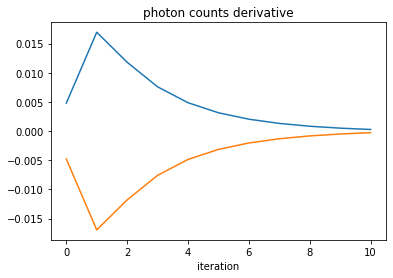

In [30]:
plt.figure()
plt.plot(diff[0])
plt.plot(diff[1])
plt.xlabel('iteration')
plt.title('photon counts derivative')

# Generalization to upsampling

The upsampling condition is $$\Delta x_s = \Delta x_d$$

Our experimental parameters are the following

In [31]:
dxd = grid.pxpitch / grid.M
dxs = 1e3*meta.dx

print(f'Δx_d = {dxd:.1f} nm')
print(f'Δx_s = {dxs:.1f} nm')

Δx_d = 165.2 nm
Δx_s = 40.0 nm


To match the upsampling condition, we have to downsample to ISM dataset by the following integer factor

In [32]:
ds = int(dxd / dxs)

print(f'Downsampling factor = {ds}')

Downsampling factor = 4


Therefore, we downsample the dataset. Then, we re-upsample by putting zero-valued pixels as place-holders.

We downsample the PSF to match the target pixel size (80 nm), namely twice the original (160 nm).

In [33]:
dset_ds = tool.DownSample(dset, ds, order ='xyc') # 160 nm pixel size
dset_up = tool.UpSample(dset_ds, 2 , 'odd', order= 'xyc') # 80 nm pixel size, every pixel with an even index is empty

psf_up = tool.DownSample(psf, 2, order ='zxyc') # 80 nm pixel size

We generate the equivalent confocal image

In [34]:
img_ds_sum = dset_ds.sum(-1) # 160 nm pixel size

We perform the s$^2$ISM reconstruction

In [35]:
img_up, *_ = s2.max_likelihood_reconstruction(dset_up, psf_up, stop='fixed', max_iter=20, rep_to_save='last')

Progress: 21it [00:02,  8.96it/s]                        


We generate a reference image at the target pixel size (80 nm).

We launch the s$^2$ISM reconstruction without upsampling.

In [36]:
dset_ref = tool.DownSample(dset, 2, order ='xyc') # 80 nm pixel size

img_ref, *_ = s2.max_likelihood_reconstruction(dset_ref, psf_up, stop='fixed', max_iter=20, rep_to_save='last')

Progress: 21it [00:02,  8.98it/s]                        


We compare the upsampled and reference image

(<Figure size 1080x720 with 12 Axes>, <AxesSubplot:label='F'>)

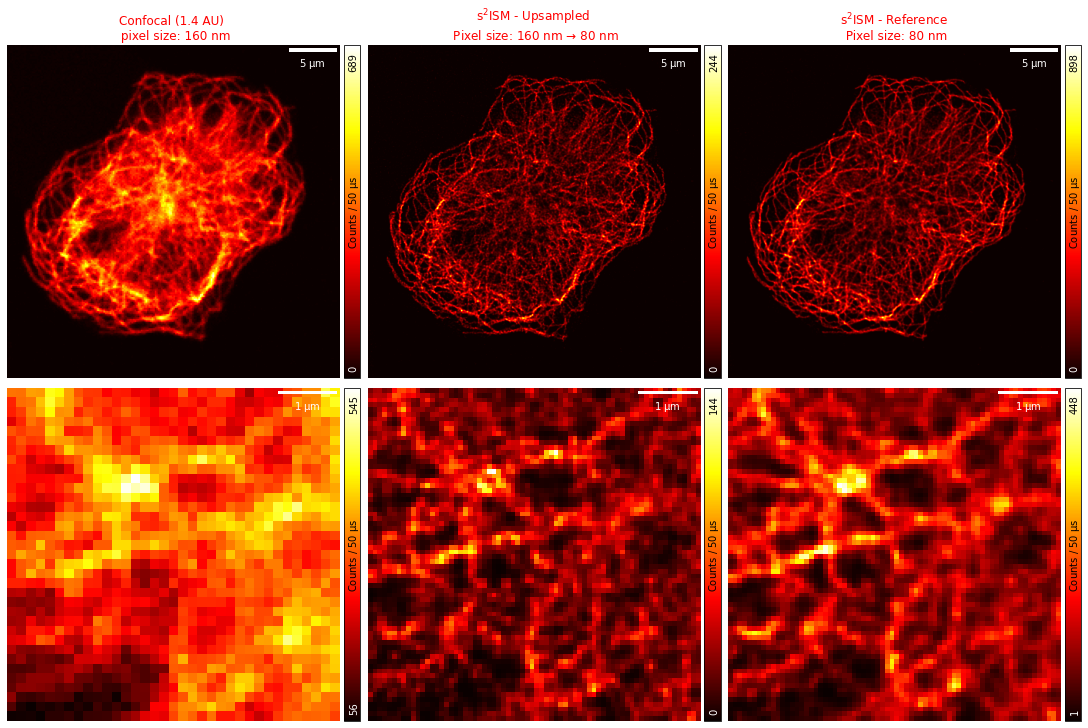

In [37]:
fig = plt.figure(layout="constrained", figsize = (15, 10))
axd =fig.subplot_mosaic(
    """
    ABC
    DEF
    """
)

axd["A"].set_title('Confocal (1.4 AU) \n pixel size: 160 nm', color = 'red')
gra.ShowImg(img_ds_sum[5:,5:], meta.dx*4, cmap='hot', fig = fig, ax = axd["A"], clabel = meta.pxdwelltime)

axd["B"].set_title('s$^2$ISM - Upsampled \n Pixel size: 160 nm $\\to$ 80 nm',  color = 'red')
gra.ShowImg(img_up[1,5:,5:], meta.dx*2, cmap='hot', fig = fig, ax = axd["B"], clabel = meta.pxdwelltime)

axd["C"].set_title('s$^2$ISM - Reference \n Pixel size: 80 nm', color = 'red')
gra.ShowImg(img_ref[1,5:,5:], meta.dx*2, cmap='hot', fig = fig, ax = axd["C"], clabel = meta.pxdwelltime)

gra.ShowImg(img_ds_sum[180//2:250//2, 135//2:205//2], meta.dx*4, cmap='hot', fig = fig, ax = axd["D"], clabel = meta.pxdwelltime)

gra.ShowImg(img_up[1, 180:250, 135:205], meta.dx*2, cmap='hot', fig = fig, ax = axd["E"], clabel = meta.pxdwelltime)

gra.ShowImg(img_ref[1,180:250, 135:205], meta.dx*2, cmap='hot', fig = fig, ax = axd["F"], clabel = meta.pxdwelltime)